# Threat Knowledge Graph: Generation, Embedding, Evaluation, and Prediction


This document shows how to generate the *threat knowledge graph* from the pre-processed `csv` files of CPE, CVE, and CWE. Then, it shows how to use [Ampligraph](https://docs.ampligraph.org/en/1.4.0/) to perform several tasks about the threat knowledge graph, including embedding, evaluation, and prediction.

## Preparation

First, import a few necessary Python packages for out tasks:

In [1]:
import numpy as np
import pandas as pd
import ampligraph

In the following, we use **AmpliGraph version 1.4.0**. [This page](https://docs.ampligraph.org/en/1.4.0/install.html) provides a guide on the installation of AmpliGraph. Note that AmpliGraph 1.4.0 is built on TensorFlow 1.x, so correct version of TensorFlow needs to be installed first (and install [CUDA](https://developer.nvidia.com/cuda-downloads) support if using Nvidia GPU for training). 

**Note:** When installing Ampligraph 1.4.0, use command `pip install ampligraph==1.4.0`. As of June 28, 2023, the latest AmpliGraph version is [2.0.0](https://docs.ampligraph.org/en/latest/index.html), which was just released on March 7, 2023. It is based on TensorFlow 2.x and has updated APIs. Currently, this document does not work with AmpliGraph 2.0.0. We plan to adopt the latest versino of AmpliGraph and update the document in the future.

After importing, check the version of AmpliGraph and make sure it is 1.4.0:

In [2]:
ampligraph.__version__

'1.4.0'

## Import the databases

In order to better process the databases in `csv` format, we import the CPE, CVE, CWE files as [Pandas DataFrames](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html). 

In the following, we mainly use the data on August 4, 2021 for demonstration.

Import CPE (the CPE entries have already been merged by version, one future work is to find better ways of merging):

In [3]:
# cpe_ignore_version.csv stores the cpes entries after merging by version
df_cpe = pd.read_csv("../processed/csv_file/2021aug/cpe_ignore_version.csv", usecols=['part','vendor',
                'product','target_sw','target_hw','name','size']).sort_values(
                'size', ascending=False)

Import CVE

In [4]:
df_cve = pd.read_csv("../processed/csv_file/2021aug/cve/cve-2002.csv")
df_cve.fillna('*', inplace = True)
for i in range(2003, 2022):
    filename = '../processed/csv_file/2021aug/cve/cve-' + str(i) + '.csv'
    df_temp = pd.read_csv(filename)
    df_temp.fillna('*', inplace = True)
    df_cve = df_cve.append(df_temp)

Import CWE, including weaknesses, categories, and views

In [5]:
df_cwe = pd.read_csv("../processed/csv_file/2021aug/cwe.csv")
df_cwe.fillna('*', inplace=True)

df_cwe_cate = pd.read_csv("../processed/csv_file/2021aug/cwe_category.csv")
df_cwe_view = pd.read_csv("../processed/csv_file/2021aug/cwe_view.csv")
df_cwe_cate.fillna('*', inplace=True)
df_cwe_view.fillna('*', inplace=True)

We can double-check the row counts of the dataframes for this version (Aug 2021) of knowledge graph:

In [6]:
print("The size of df_cpe, df_cve, df_cwe are:", df_cpe.shape[0], df_cve.shape[0], df_cwe.shape[0])

The size of df_cpe, df_cve, df_cwe are: 68338 167542 918


**Remark:** Note that the entire CWE is stored in three dataframes: `df_cwe` for weaknesses, `df_cwe_cate` for weakness categories, and `df_cwe_view` for weakness views. Currently, we take the weaknesses as the main entities (nodes) in the knowledge graph, while the other two types are considered as the attributes of weaknesses.
In the future, perhaps we can merge them all into one dataframe, and differentiate them by labels (view, category, pillar, class, base, variant) according to the [CWE hierachy](https://cwe.mitre.org/documents/cwe_usage/guidance.html#helpful_resources).

## Generate knowledge graph triples

We generate knowledge graph triples ([head entity, relation, tail entity]) from the dataframes. The triples will be stored in a list (e.g., [[h1, r1, t1], [h2, r2, t2], ...]).

We start with the CWE triples. The CWE Weakness entries are stored in `kg_cwe`, Category entries are stored in `kg_cate`, and View entries are stored in `kg_view`. In the meantime, we also save all the CWE entries in a list named `cwe_list` for later use.

In [7]:
cwe_list = []

kg_cwe = []

for i,r in df_cwe.iterrows():
    cweid = r['ID']

    cwe_list.append(cweid)

    if (r['Related_Weakness'] != '*'):
        relatedlist = r['Related_Weakness'].split(';')
        for re in relatedlist:
            relation, other = re.split(':')
            other = 'CWE-' + other
            kg_cwe.append(([cweid, relation, other]))

    if (r['Language'] != '*'):
        langlist = r['Language'].split(';')
        for l in langlist:
            if (l != 'Language-Independent'):
                kg_cwe.append(([cweid, 'Language', l]))

    if (r['Technology'] != '*'):
        techlist = r['Technology'].split(';')
        for t in techlist:
            if (t != 'Technology-Independent'):
                kg_cwe.append(([cweid, 'Technology', t]))

    if (r['Likelihood_Of_Exploit'] != '*'):
        kg_cwe.append(([cweid, 'LikelihoodOfExploit', \
                        r['Likelihood_Of_Exploit']]))

    if (r['Consequence'] != '*'):
        conseqlist = r['Consequence'].split(';')
        for c in conseqlist:
            if (c != 'Other'):
                kg_cwe.append(([cweid, 'Consequence', c]))

In [8]:
kg_cate = []
kg_view = []

for i,r in df_cwe_cate.iterrows():
    cid = r['ID']

    if (r['Has_Member'] != '*'):
        memlist = r['Has_Member'].split(';')
        for m in memlist:
            kg_cate.append(([cid, 'Has_Member', m]))

for i,r in df_cwe_view.iterrows():
    vid = r['ID']

    if (r['Has_Member'] != '*'):
        memlist = r['Has_Member'].split(';')
        for m in memlist:
            kg_view.append(([vid, 'Has_Member', m]))

In [our previous paper](https://ieeexplore.ieee.org/abstract/document/9973028) published on IEEE SecDev 2022, we explained that, one optimization we made is to remove the CPE and CVE entries that are not connected to other nodes.

For this purpose, we next generate a candidate list of valid CPE entries. Note that this is only a temporal list for filtering, we will remove CPE entries that are not associated (connected) to CVE entries (nodes) later.

In [9]:
cpe_candidate_list = []

for i, r in df_cpe.iterrows():
    cpe_candidate_list.append(r['name'])

As the CVE connects the CPE and CWE, we generate the CVE triples in two types: `kg_cpe2cve` includes the triples between CVE and CPE ([cpe-x, MatchingCVE, cve-y]), and `kg_cve2cwe` includes the triples between CVE and CWE ([cve-y, MatchingCWE, cwe-z]). The CVE dataframe also includes CVE entries without any connections to the other two databases, and we discard those entries. The triples related to CVE are stored in `kg_cve`, which will then be the combination of `kg_cpe2cve` and `kg_cve2cwe`.

As there might exist a small portion of inconsistency between the CPE names in the CPE and CVE, we use `cpe_candidate_list` to filter out triples with invalid CPE names. We also use `cwe_list` to filter out invalid CWE names. `cve_candidate_list` has all the CVEs in the dataframe. 

We store the remaining CVE entries after filtering out unconnected nodes in a list called `connected_cvelist`. In the meantime, the remaining CPE entries are stored in the list `connected_cpelist`.

In [10]:
cve_candidate_list = []
connected_cvelist = []

kg_cve = []
kg_cpe2cve = []
kg_cve2cwe = []

connected_cpelist = [] # for saving cpes that are connected to cves

for i,r in df_cve.iterrows():
    cveid = r['ID']
    cve_candidate_list.append(cveid)
    is_connected = 0

    if (r['MatchingCPE'] != '*'):
        cpes_related = r['MatchingCPE'].split(';')
        plist = []
        for p in cpes_related:

            # replace characters that may cause problems
            p = p.replace('\,', '\.')
            p = p.replace('\:', '\;')
            p = p.replace('"', "'")

            p_detail = p.split(':')
            pp = ':'.join(['cpe']+p_detail[2:5]+p_detail[10:12])
            if (pp not in plist)  and (pp in cpe_candidate_list):
                matchcpe = [pp, 'MatchingCVE', cveid]
                kg_cpe2cve.append((matchcpe))
                is_connected += 1

            if pp not in connected_cpelist and (pp in cpe_candidate_list):
                connected_cpelist.append(pp)

            plist.append(pp)

        if (r['MatchingCWE'] != '*' and r['MatchingCWE'] != 'NVD-CWE-Other' and r['MatchingCWE'] != 'NVD-CWE-noinfo'):
            cwelist = r['MatchingCWE'].split(';')
            for w in cwelist:
                if (w != 'NVD-CWE-noinfo') and (w in cwe_list):
                    matchcwe = [cveid, 'MatchingCWE', w]
                    kg_cve2cwe.append((matchcwe))
                    is_connected += 1

    if is_connected:
        connected_cvelist.append(cveid)
        is_connected = 0

kg_cve = kg_cpe2cve + kg_cve2cwe

There are a few things worth mentioning about this process: (i) in the CVE dataframe, the matched CPEs are not merged, so we need to produce its merged name as `pp`; (ii) due to merging CPEs, we will have duplicate triples, so we maintain `plist` to avoid duplication; (iii) if a CVE is matched to `NVD-CWE-Other` or `NVD-CWE-noinfo`, we simply discard those mappings; (iv) if `is_connected` is positive, the CVE is connected and will be added to `connected_cvelist`.

As the code block above can take a while to run, we would like to store `connected_cpelist` and `connected_cvelist` in a separate file, which will be used often in the following. (The CWE list can be stored similarly.)

In [11]:
# save connected_cpelist locally
with open('.\saved\cpelist_connected.txt', 'w') as f:
    for items in connected_cpelist:
        f.write('%s\n' %items)
    print("File written successfully")
f.close()

File written successfully


In [12]:
# save connected_cvelist locally
with open('.\saved\cvelist_connected.txt', 'w') as f:
    for items in connected_cvelist:
        f.write('%s\n' %items)
    print("File written successfully")
f.close()

File written successfully


In [8]:
# load connected_cpelist
f = open('.\saved\cpelist_connected.txt', 'r')
connected_cpelist = f.read().splitlines()
f.close()

In [9]:
# load connected_cvelist
f = open('.\saved\cvelist_connected.txt', 'r')
connected_cvelist = f.read().splitlines()
f.close()

`kg_cpe2cve` and `kg_cve2cwe` are also important, as these two types of triples are exactly what we will try to predict with the knowledge graph. Thus, it is worthwhile to save them to separate files as well.

In [15]:
# save kg_cpe2cve and kg_cve2cwe locally
cpe2cve_df = pd.DataFrame(kg_cpe2cve, columns=["subject", "predicate", "object"])
cpe2cve_df.to_csv('./saved/cpe2cve-aug2021.csv', index=False)

cve2cwe_df = pd.DataFrame(kg_cve2cwe, columns=["subject", "predicate", "object"])
cve2cwe_df.to_csv('./saved/cve2cwe-aug2021.csv', index=False)

In [10]:
# load kg_cpe2cve and kg_cve2cwe
kg_cpe2cve = []
kg_cve2cwe = []

kg_cpe2cve_df = pd.read_csv("./saved/cpe2cve-aug2021.csv")
for i,r in kg_cpe2cve_df.iterrows():
    kg_cpe2cve.append([r['subject'],r['predicate'],r['object']])

kg_cve2cwe_df = pd.read_csv("./saved/cve2cwe-aug2021.csv")
for i,r in kg_cve2cwe_df.iterrows():
    kg_cve2cwe.append([r['subject'],r['predicate'],r['object']])

kg_cve = kg_cpe2cve + kg_cve2cwe

After getting `connected_cpelist`, we are able to generate triples about the connected CPEs, saved in `kg_cpe`

In [11]:
kg_cpe = []

for i, r in df_cpe.iterrows():
    cpeid = r['name']

    if cpeid in connected_cpelist:
        kg_cpe.append([cpeid, "Part", r['part']])
        kg_cpe.append([cpeid, "Vendor", r['vendor']])
        kg_cpe.append([cpeid, "Product", r['product']])
        if (r['target_sw'] != "*"):
            kg_cpe.append([cpeid, "Target_sw", r['target_sw']])
        if (r['target_hw'] != "*"):
            kg_cpe.append([cpeid, "Target_hw", r['target_hw']])

With all the lists of triples, we are ready to combine them to get the entire knowledge graph

In [14]:
triples = kg_cpe + kg_cve + kg_cwe + kg_cate + kg_view

The entire knowledge graph in triple form can be saved and read as a local file

In [88]:
# save knowledge graph triples locally
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
triples_df.to_csv('./saved/kg_demo_aug2021.csv', index=False)

In [12]:
# load knowledge graph triples
triples = []
triples_df = pd.read_csv("./saved/kg_demo_aug2021.csv", usecols=["subject", "predicate", "object"])

for i,r in triples_df.iterrows():
    triples.append([r['subject'],r['predicate'],r['object']])

We can double-check the size of the knowledge graph, which is (390138, 3) in our case.

In [13]:
triples_df.shape

(390138, 3)

## Knowledge graph embedding

Now that we have the threat knowledge graph stored as a list of triples, we can perform the task of knowledge graph embedding, which translates the entities and relations in triples as vectors in a vector space.

To prepare for training the embedding model, we split the knowledge graph into training set and test set. We set the size of test set as 10,000. `X_train` and `X_valid` will be two numpy arrays that contain the training and test set, respectively.

In [22]:
from ampligraph.evaluation import train_test_split_no_unseen

X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=10000)

Note that the train-test split is performed randomly using built-in fuction of Ampligraph. Ampligraph makes sure that the test set contains only entities and relations which also occur in the training set. For the reproducibility of our results, we can store the training and test sets as `csv` files.

In [91]:
# save training and test sets locally
train_df = pd.DataFrame(X_train, columns=["subject", "predicate", "object"])
train_df.to_csv('./saved/kg_demo_train_aug2021.csv', index=False)

valid_df = pd.DataFrame(X_valid, columns=["subject", "predicate", "object"])
valid_df.to_csv('./saved/kg_demo_valid_aug2021.csv', index=False)

In [14]:
# load local training and test sets
train_df = pd.read_csv("./saved/kg_demo_train_aug2021.csv", usecols=["subject", "predicate", "object"])
valid_df = pd.read_csv("./saved/kg_demo_valid_aug2021.csv", usecols=["subject", "predicate", "object"])

X_train = train_df.to_numpy()
X_valid = valid_df.to_numpy()

We can double-check the size of training and test sets and make sure they add up to the size of the entire knowledge graph.

In [15]:
print('Train set size: ', X_train.shape)
print('Test set size: ', X_valid.shape)

Train set size:  (380138, 3)
Test set size:  (10000, 3)


Ampligraph has provided a few built-in embedding models, including TransE, DistMult, ComplEx, and HolE. The models that we tested are listed below, with sets of good parameters we used (the parameters can be further fine-tuned). The explanations of the parameters can be found on [Ampligraph website](https://docs.ampligraph.org/en/1.4.0/generated/ampligraph.latent_features.TransE.html#ampligraph.latent_features.TransE).

In [16]:
from ampligraph.latent_features import TransE, DistMult, ComplEx

model_transe = TransE(batches_count=50,
                epochs=300,
                k=100,
                eta=20,
                embedding_model_params={'corrupt_sides': ['s,o'], 'negative_corruption_entities': 'batch'},
                optimizer='adam',
                optimizer_params={'lr':1e-4},
                loss='multiclass_nll',
                regularizer="LP",
                regularizer_params={'p':3, 'lambda':1e-5},
                seed=0,
                verbose=True)

model_distmult = DistMult(batches_count=50,
                epochs=300,
                k=300,
                eta=20,
                embedding_model_params={'corrupt_sides': ['s,o'], 'negative_corruption_entities': 'batch'},
                optimizer='adam',
                optimizer_params={'lr':1e-4},
                loss='multiclass_nll',
                regularizer='LP',
                regularizer_params={'p':3, 'lambda':1e-5},
                seed=0,
                verbose=True)

model_complex = ComplEx(batches_count=50,
                epochs=300,
                k=200,
                eta=20,
                embedding_model_params={'corrupt_sides': ['s,o'], 'negative_corruption_entities': 'batch'},
                optimizer='adam',
                optimizer_params={'lr':1e-4},
                loss='multiclass_nll',
                regularizer='LP',
                regularizer_params={'p':3, 'lambda':1e-5},
                seed=0,
                verbose=True)

By comparing the three models, we found that using TransE model yielded the best embedding metrics. In the following, we will use TransE model with the parameters specified above as an example.

Next, we train the embedding model with `X_train` from our knowledge graph

In [60]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

model_transe.fit(X_train)

Average TransE Loss:   0.188538: 100%|██████████| 300/300 [05:24<00:00,  1.08s/epoch]


We can save the trained model locally for reuse:

In [61]:
# save trained embedding model locally
from ampligraph.latent_features import save_model
save_model(model_transe, './saved/kg_demo_model_transe_aug2021.pkl')

In [17]:
# load trained embedding model
from ampligraph.latent_features import restore_model
model_transe = restore_model('./saved/kg_demo_model_transe_aug2021.pkl')

The quality of embedding is typically evaluated by a few [embedding metrics](https://docs.ampligraph.org/en/1.4.0/ampligraph.evaluation.html#metrics), including Mean Rank, Mean Reciprocal Rank, and Hits@N Scores. These metrics can also be used for evaluating how well the future triples can be predicted.

In order to compute the embedding metrics, Ampligraph requires a list of "filter triples", which is used for filtering out positive triples when it randomly generating negative triples. This can be set as all the knowledge graph triples, which we know are positive:

In [18]:
filter_triples = np.concatenate((X_train, X_valid))

Then, the embedding metrics can be computed using the test set, using AmpliGraph's [`evaluate_performance`](https://docs.ampligraph.org/en/1.4.0/generated/ampligraph.evaluation.evaluate_performance.html#ampligraph.evaluation.evaluate_performance) function. Each triple in the test set will be ranked (ordered) against the negative triples. The negative triples are generated by replacing the head or tail entity of the test triple by other valid entities, and discarding triples specified by `filter_triples`. 

In [63]:
from ampligraph.evaluation import evaluate_performance

ranks = evaluate_performance(X_valid,
                             model=model_transe,
                             filter_triples=filter_triples,
                             verbose=True)

WARNING - You are attempting to use 185306 distinct entities to generate synthetic negatives in the evaluation
    protocol. This may be unnecessary and will lead to a 'harder' task. Besides, it will lead to a much slower
    evaluation procedure. We recommended to set the 'corruption_entities' argument to a reasonably sized set
    of entities. The size of corruption_entities depends on your domain-specific task.


d:\Softwares\Anaconda\envs\ampligraph\lib\site-packages\ampligraph\evaluation\protocol.py:952: UserWarning: You are attempting to use 185306 distinct entities to generate synthetic negatives in the evaluation
    protocol. This may be unnecessary and will lead to a 'harder' task. Besides, it will lead to a much slower
    evaluation procedure. We recommended to set the 'corruption_entities' argument to a reasonably sized set
    of entities. The size of corruption_entities depends on your domain-specific task.
  warnings.warn(warn_msg % ent_for_corruption_size)
100%|██████████| 10000/10000 [02:35<00:00, 64.13it/s]


**Remark:** In fact, it is not recommended to use all the entities when generating the negative triples, so we will get a warning here. Nonetheless, it is a convenient way to roughly evaluate the overall embedding quality.

We can then print the embedding metrics.

In [64]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.3f" % (mrr))
print("MR: %.3f" % (mr))

hits_20 = hits_at_n_score(ranks, n=20)
print("Hits@20: %.3f" % (hits_20))
hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.3f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.3f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.3f" % (hits_1))

MRR: 0.279
MR: 13471.000
Hits@20: 0.430
Hits@10: 0.386
Hits@3: 0.304
Hits@1: 0.224


In addition to the overall metrics for the entire knowledge graph, we can also get the metrics for specific types of triples, which are CPE-CVE and CVE-CWE triples in our case.

To do so, we need to update the test set, such that it only contains CPE-CVE or CVE-CWE triples. As a result, we have two new test sets `test_pv` and `test_vw` selected from the previous test set.

In [19]:
test_pv = []
test_vw = []
for r in X_valid:
    if r[1] == "MatchingCVE":
        test_pv.append(r)
    elif r[1] == "MatchingCWE":
        test_vw.append(r)

For CPE-CVE triples, we replace the CPE side by other valid CPEs from `connected_cpelist` when generating negative triples. Generating negative triples from the triples in the test set is also called "corruption". The `corrupt_side` parameter specifies the side to replace, where `s` represents subject (head entity) and `o` represents object (tail entity). The `entities_subset` parameter specifies the entities for replacement. Here, we set `corrupt_side='s'` and `entities_subset=connected_cpelist`.

**Remark:** The metrics will also reflect how well we can predict CPEs that are associated to a given CVE (closed-world evaluation). Predicting in the other direction (CPE->CVE) does not give good performance, so we skip it here. In general, we get good metrics when predicting the smaller side (CPE, CWE) given the larger side (CVE).

In [65]:
ranks = evaluate_performance(np.array(test_pv),
                             model=model_transe,
                             filter_triples=filter_triples,
                             entities_subset=connected_cpelist,
                             corrupt_side='s',
                             verbose=True)

d:\Softwares\Anaconda\envs\ampligraph\lib\site-packages\ampligraph\latent_features\models\EmbeddingModel.py:1329: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if corruption_entities == 'all':
100%|██████████| 5576/5576 [00:24<00:00, 228.71it/s]


In [66]:
mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.3f" % (mrr))
print("MR: %.3f" % (mr))

hits_20 = hits_at_n_score(ranks, n=20)
print("Hits@20: %.3f" % (hits_20))
hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.3f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.3f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.3f" % (hits_1))

MRR: 0.423
MR: 1777.968
Hits@20: 0.626
Hits@10: 0.579
Hits@3: 0.463
Hits@1: 0.345


Similarly, we can get rank-based metrics for CVE->CWE triples, by replacing the CWE side with other valid CWEs in `cwe_list`. For this purpose, we set `corrupt_side='o'` (i.e., tail entity) and `entities_subset=cwe_list`.

In [67]:
ranks = evaluate_performance(np.array(test_vw),
                             model=model_transe,
                             filter_triples=filter_triples,
                             entities_subset=cwe_list,
                             corrupt_side='o',
                             verbose=True)

100%|██████████| 2332/2332 [00:32<00:00, 72.24it/s]


In [68]:
mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.3f" % (mrr))
print("MR: %.3f" % (mr))

hits_20 = hits_at_n_score(ranks, n=20)
print("Hits@20: %.3f" % (hits_20))
hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.3f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.3f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.3f" % (hits_1))

MRR: 0.419
MR: 16.091
Hits@20: 0.813
Hits@10: 0.705
Hits@3: 0.480
Hits@1: 0.283


It is good to see that the metrics for CPE-CVE or CVE-CWE triples are even better than those for the entire knowledge graph, since these two types of triples are what we really want to predict.

## Predict new triples: MR, MRR, Hits@N

We can use the embedded knowledge graph to predict unknown triples that are similar to the existing ones. To do so, we feed a new triple to the trained embedding model, which will score the triple - the higher the score is, the more likely the triple is positive.

In this section, we evaluate how well the triples between Aug 4, 2021 and Nov 1, 2022 can be predicted, using the embedding model trained by the Aug 2021 version of knowledge graph (open-world evaluation).

Under the `Tutorials/intro_ampligraph/saved/` folder, we have stored Nov 2022 version of `kg_cpe2cve` (`cpe2cve-nov2022.csv`) and `kg_cve2cwe` (`cve2cwe-nov2022.csv`) for this demonstration. Using them, we can get the new triples since Aug 2021.

First, we load the Nov 2022 version of `kg_cpe2cve` and `kg_cve2cwe` from saved files.

In [20]:
kg_cpe2cve_nov2022 = []

kg_cpe2cve_nov2022_df = pd.read_csv("./saved/cpe2cve-nov2022.csv")
for i,r in kg_cpe2cve_nov2022_df.iterrows():
    kg_cpe2cve_nov2022.append([r['subject'],r['predicate'],r['object']])

kg_cve2cwe_nov2022 = []

kg_cve2cwe_2022_df = pd.read_csv("./saved/cve2cwe-nov2022.csv")
for i,r in kg_cve2cwe_2022_df.iterrows():
    kg_cve2cwe_nov2022.append([r['subject'],r['predicate'],r['object']])

Then, we can get the new CPE-CVE and CVE-CWE triples from Aug 4, 2021 to Nov 1, 2022. We will use the new triples to form the new test set, which will be used for evaluating the prediction capability. If the triples in the new test set are assigned high scores by the trained embedding model, then we know that the model can predict future triples well. Note that, in the test set, we only include triples that involve entities already existing by Aug 2021 (the head and tail entities of the triple must be already included in the Aug 2021 knowledge graph).

The following code blocks generate a test set `new_test_cve2cwe` of new CVE-CWE triples from Aug 2021 to Nov 2022, and save it as a local file.

In [31]:
new_cve2cwe = []

li1 = []
li2 = []
for l in kg_cve2cwe_nov2022:
    li1.append(l[0]+','+l[1]+','+l[2])
for l in kg_cve2cwe:
    li2.append(l[0]+','+l[1]+','+l[2])

new_tmp = list(set(li1) - set(li2))
for s in new_tmp:
    new_cve2cwe.append(s.split(','))

new_cve2cwe_df = pd.DataFrame(new_cve2cwe,columns=["subject", "predicate", "object"]).sort_values(by=['subject'], ascending=True).reset_index(drop=True)

In [36]:
# keep only the relations between existing nodes
new_test_cve2cwe = []

kg_cve2cwe_df = pd.DataFrame(kg_cve2cwe, columns=["subject", "predicate", "object"])
for i, r in new_cve2cwe_df.iterrows():
    if r['subject'] in connected_cvelist:
        new_test_cve2cwe.append(r)

In [37]:
# save new_test_cve2cwe locally
new_test_cve2cwe_df = pd.DataFrame(new_test_cve2cwe, columns=["subject", "predicate", "object"])
new_test_cve2cwe_df.to_csv('./saved/new_test_cve2cwe_aug2021_nov2022.csv', index=False)

Similarly, the following code blocks generate a test set `new_test_cpe2cve` of new CPE-CVE triples from Aug 2021 to Nov 2022.

In [38]:
new_cpe2cve = []

li1 = []
li2 = []
for l in kg_cpe2cve_nov2022:
    li1.append(l[0]+','+l[1]+','+l[2])
for l in kg_cpe2cve:
    li2.append(l[0]+','+l[1]+','+l[2])

new_tmp = list(set(li1) - set(li2))
for s in new_tmp:
    new_cpe2cve.append(s.split(','))

new_cpe2cve_df = pd.DataFrame(new_cpe2cve, columns=["subject", "predicate", "object"]).sort_values(by=['subject'], ascending=True).reset_index(drop=True)

In [39]:
# keep only the relations between existing nodes
new_test_cpe2cve = []

kg_cpe2cve_df = pd.DataFrame(kg_cpe2cve, columns=["subject", "predicate", "object"])
for i, r in new_cpe2cve_df.iterrows():
    if r['subject'] in connected_cpelist:
        if r['object'] in connected_cvelist:
            new_test_cpe2cve.append(r)

In [40]:
# save new_test_cpe2cve locally
new_test_cpe2cve_df = pd.DataFrame(new_test_cpe2cve, columns=["subject", "predicate", "object"])
new_test_cpe2cve_df.to_csv('./saved/new_test_cpe2cve_aug2021_nov2022.csv', index=False)

The saved test sets can be loaded directly next time.

In [21]:
# load new_test_cve2cwe
new_test_cve2cwe= []

new_test_cve2cwe_df = pd.read_csv("./saved/new_test_cve2cwe_aug2021_nov2022.csv")
for i,r in new_test_cve2cwe_df.iterrows():
    new_test_cve2cwe.append([r['subject'],r['predicate'],r['object']])

In [22]:
# load new_test_cpe2cve
new_test_cpe2cve = []

new_test_cpe2cve_df = pd.read_csv("./saved/new_test_cpe2cve_aug2021_nov2022.csv")
for i,r in new_test_cpe2cve_df.iterrows():
    new_test_cpe2cve.append([r['subject'],r['predicate'],r['object']])

This time, we use all the triples on Aug 4, 2021 for training the TransE embedding model.

In [75]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

model_transe.fit(np.concatenate((X_train, X_valid)))

Average TransE Loss:   0.191692: 100%|██████████| 300/300 [05:17<00:00,  1.06s/epoch]


In [76]:
# save trained embedding model locally
from ampligraph.latent_features import save_model
save_model(model_transe, './saved/kg_all_model_transe_aug2021.pkl')

In [77]:
# load trained embedding model
from ampligraph.latent_features import restore_model
model_transe = restore_model('./saved/kg_all_model_transe_aug2021.pkl')

Next, we are ready to test how well the embedded knowledge graph can predict the triples in `new_test_cpe2cve` and `new_test_cve2cwe`, using MR, MRR, and Hits@N scores.

This time, we have more positive triples, so we need to update the filter triples first.

In [23]:
filter_triples_new = np.concatenate((X_train, X_valid, np.array(new_test_cpe2cve + new_test_cve2cwe)))

We can get the embedding metrics for the new 11,971 CPE-CVE triples.

In [80]:
from ampligraph.evaluation import evaluate_performance

ranks = evaluate_performance(np.array(new_test_cpe2cve),
                             model=model_transe,
                             filter_triples=filter_triples_new,
                             entities_subset=connected_cpelist,
                             corrupt_side='s',
                             verbose=True)

100%|██████████| 11971/11971 [00:59<00:00, 200.03it/s]


In [81]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.3f" % (mrr))
print("MR: %.3f" % (mr))

hits_20 = hits_at_n_score(ranks, n=20)
print("Hits@20: %.3f" % (hits_20))
hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.3f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.3f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.3f" % (hits_1))

MRR: 0.189
MR: 1416.827
Hits@20: 0.442
Hits@10: 0.349
Hits@3: 0.211
Hits@1: 0.111


Similarly, we can get the metrics for the new 1,652 CVE-CWE triples.

In [78]:
ranks = evaluate_performance(np.array(new_test_cve2cwe),
                             model=model_transe,
                             filter_triples=filter_triples_new,
                             entities_subset=cwe_list,
                             corrupt_side='o',
                             verbose=True)

d:\Softwares\Anaconda\envs\ampligraph\lib\site-packages\ampligraph\latent_features\models\EmbeddingModel.py:1329: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if corruption_entities == 'all':
100%|██████████| 1652/1652 [00:10<00:00, 161.60it/s]


In [79]:
mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.3f" % (mrr))
print("MR: %.3f" % (mr))

hits_20 = hits_at_n_score(ranks, n=20)
print("Hits@20: %.3f" % (hits_20))
hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.3f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.3f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.3f" % (hits_1))

MRR: 0.173
MR: 39.125
Hits@20: 0.544
Hits@10: 0.389
Hits@3: 0.176
Hits@1: 0.070


The open-world metrics are worse than the closed-world metrics in the last section. Still, they suggest that we can make useful predictions at some level.

The embedding model will assign a score to each triple, and we can compute the scores for the new triples.

In [82]:
from scipy.special import expit

new_test = np.array(new_test_cpe2cve + new_test_cve2cwe)
scores = model_transe.predict(new_test)

Note that the important thing is that the positive triples are ranked/ordered before negative triples, so the values of the scores do not matter (in our example they are pretty small), as long as the scores of positive triples are higher than negative ones.

## Predict new triples: precision, recall, F1-score

Other than the typical knowledge-graph-related metrics, we can also get prediction-related metrics, including precision, recall, and F1-score.

The triples in `new_test_cpe2cve` and `new_test_cve2cwe` will be the positive triple in our test. To compute precision and recall, we also need to manually generate negative triples to compute the rates of True Positive, True Negative, False Positive, and False Negative.

For each CVE shown in the new CPE-CVE triples, we generate 50 negative triples by randomly selecting CPEs (positive triples will be filtered out), stored in `neg_test_cpe2cve`.

In [50]:
import random

neg_test_cpe2cve = []

dict_cpe2cve = {} # cve as key, replace cpe
dict_cve2cpe = {} # cpe as key, replace cve

cpe2cve_alltime = new_test_cpe2cve + kg_cpe2cve

for i in range(len(cpe2cve_alltime)):
    if cpe2cve_alltime[i][2] not in dict_cpe2cve.keys():
        dict_cpe2cve[cpe2cve_alltime[i][2]] = []
    dict_cpe2cve[cpe2cve_alltime[i][2]].append(cpe2cve_alltime[i][0])

    if cpe2cve_alltime[i][0] not in dict_cve2cpe.keys():
        dict_cve2cpe[cpe2cve_alltime[i][0]] = []
    dict_cve2cpe[cpe2cve_alltime[i][0]].append(cpe2cve_alltime[i][2])

test_cves = []
for i in range(len(new_test_cpe2cve)):
    if new_test_cpe2cve[i][2] not in test_cves:
        test_cves.append(new_test_cpe2cve[i][2])

for v in test_cves:
    rnd_lst = []
    while len(rnd_lst) < 50:
        rnd_cpe = random.choice(connected_cpelist)
        if rnd_cpe not in dict_cpe2cve[v]:
            rnd_lst.append(rnd_cpe)
    for p in rnd_lst:
        neg_test_cpe2cve.append([p,'MatchingCVE',v])

Save the generated negative triples for reproducibility, which can be read from the saved file next time.

In [51]:
# save generated negative CPE-CVE triples locally
neg_test_cpe2cve_df = pd.DataFrame(neg_test_cpe2cve, columns=["subject", "predicate", "object"])
neg_test_cpe2cve_df.to_csv('./saved/neg_test_cpe2cve.csv', index=False)

In [24]:
# load generated negative CPE-CVE triples
neg_test_cpe2cve = []

neg_test_cpe2cve_df = pd.read_csv("./saved/neg_test_cpe2cve.csv")
for i,r in neg_test_cpe2cve_df.iterrows():
    neg_test_cpe2cve.append([r['subject'],r['predicate'],r['object']])

We use a numpy array `is_pos` to mark the positivity or negativitiy of the triples (new triples and generated negative triples).

In [25]:
is_pos = []

for i in range(len(new_test_cpe2cve)):
    is_pos.append(1)
for i in range(len(neg_test_cpe2cve)):
    is_pos.append(0)

is_pos = np.asarray(is_pos)

The scores of the postive and negative triples can be then computed.

In [83]:
test = np.array(new_test_cpe2cve + neg_test_cpe2cve)
scores = model_transe.predict(test)

For the new triples and generated negative triples, we can compute their probabilities of positivity predicted by the embedded knowledge graph. The probabilities are the scores normalized scores (assigned by the embedding model). 

There exist different ways to normalize the scores, and different embedding models ususally need different normalization functions. For example, if DistMult or ComplEx model is used for embedding, one choice is to use $expit()$ function.

For the TransE model we are using, min-max normalization can give us well distributed probabilities.

In [84]:
import math

probs = []

## standard min-max normalization
# min_score, max_score = min(scores), max(scores)

## adjusted normalization such that the probabilities are strictly between 0 and 1
min_score, max_score = math.floor(min(scores)), math.ceil(max(scores))

for s in scores:
    probs.append(max(0, (s-min_score)/(max_score-min_score)))

## for ComplEx model, use the following code instead
# from scipy.special import expit
# probs = expit(scores)

We can then save the prediction results in a `.csv` file. The triples are sorted by predicted probability. We find that most of postive triples are ranked before negative triples.

In [85]:
pred = pd.DataFrame(list(zip([' '.join(x) for x in test],
                      np.squeeze(scores),
                      np.squeeze(probs),
                      np.squeeze(is_pos))),
             columns=['statement', 'score', 'prob', 'is_positive']).sort_values('score', ascending=False)

pred.to_csv('./saved/predict_cpe2cve_neg50.csv', index=False)

Next, with the predicted probabilities of the triples, we can draw precision-recall curve. The curve shows how the precision and recall change as the threshold for positivity changes.

d:\Softwares\Anaconda\envs\ampligraph\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  from ipykernel import kernelapp as app
d:\Softwares\Anaconda\envs\ampligraph\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  app.launch_new_instance()


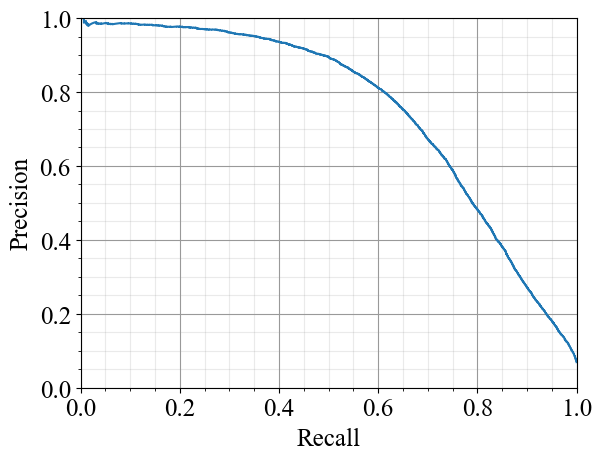

In [86]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(is_pos, probs)

fig, ax = plt.subplots()
ax.plot(recall[50:-10], precision[50:-10])
plt.xlim([0,1])
plt.ylim([0,1])
plt.xticks(fontfamily = 'Times New Roman', fontsize=18)
plt.yticks(fontfamily = 'Times New Roman', fontsize=18)
plt.ylabel('Precision', fontfamily = 'Times New Roman', fontsize = 18)
plt.xlabel('Recall', fontfamily = 'Times New Roman', fontsize = 18)

plt.grid(b=True, which='major', color='#999999', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.savefig("./saved/prc_cpe2cve_neg50.pdf",bbox_inches ="tight", pad_inches = 0.15)
plt.show()

Given the precision-recall curve, we can compute the best F1-score for our example.

In [87]:
numerator = 2 * recall * precision
denom = recall + precision
f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))

print('Best threshold: ', thresholds[np.argmax(f1_scores)])
print('Precision and recall: ', precision[np.argmax(f1_scores)], recall[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))

Best threshold:  0.5949201583862305
Precision and recall:  0.7506967803940413 0.6524935260212179
Best F1-Score:  0.6981587415087593


In this example, when we set the probability threshold for positivity as 0.595, we get the optimal F1-score of 0.698, with precision of 0.751 and recall of 0.652.

The precision-recall curve becomes worse as we include more negative triples in the test set.

Similary, we can plot the precision-recall curve for CVE-CWE triples. Note that the number of candidate CWEs (about 900) for generating negative triples is significantly smaller than the number of candidate CPEs (about 28,000). To make the curve look nice, we can try a smaller number of negative triples (e.g., 10 negative CVE-CWE triples for each CVE in positive ones).